In [1]:
import torch
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Tanh
from torch.nn import Sigmoid
from torch.nn import Module
from torch.nn import Embedding 
from torch.optim import SGD,Adam
from torch.nn import CrossEntropyLoss, BCELoss, MSELoss
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error
import numpy as np
from numpy import vstack
from sklearn.decomposition import PCA
from torch.utils.data import random_split
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
# model definition
class RNN(Module):
    # define model elements
    # n_inputs: input dimension
    # n_hidden: number of neurons per layer
    # n_layers: number of hidden layers
    def __init__(self, n_hidden, n_layers, input_dim):
        super(RNN, self).__init__()
        
        # hidden layers
        #self.embed = Embedding(input_dim, embedding_dim) 
        self.hidden = {}
        self.act = {}
        for i in range(n_layers):
            if i==0:
                n_in = input_dim + n_hidden # embedding_dim + n_hidden
            else:
                n_in = n_hidden * 2
            # input to hidden layer
            self.hidden[i] = Linear(n_in, n_hidden)
            kaiming_uniform_(self.hidden[i].weight, nonlinearity='relu')
            # non-linearity
            self.act[i] = Tanh() # or ReLu
        
        # output
        self.out = Linear(n_hidden,input_dim) # dimension of output is 2
        xavier_uniform_(self.out.weight)
        #self.actout = Sigmoid()
        
        
    # forward propagate input
    def forward(self, X, hidden_layer):
        n_layers = len(hidden_layer)
        #idx = torch.argmax(X,-1)
        #embedding = self.embed(idx)
        for i in range(n_layers):
            if i == 0:
                # combine input with previous hidden
                combined = torch.cat((X, hidden_layer[i]), 1)
            else:
                # combine previous hidden with hidden
                combined = torch.cat((hidden_layer[i-1], hidden_layer[i]), 1)
            # input to hidden layer
            hidden_layer[i] = self.hidden[i](combined)
            hidden_layer[i] = self.act[i](hidden_layer[i])
            
        ## output
        output = self.out(hidden_layer[i])
        #output = self.actout(output)

        return output,hidden_layer

In [3]:
# train the model
def train_model(train_x,train_y, model):
    n_layers = len(model.hidden)
    n_hidden = model.hidden[0].weight.size()[0]
    # define the optimization
    criterion = MSELoss()
    optimizer = Adam(model.parameters(), lr=0.05)
    
    # enumerate epochs
    all_loss = []
    lossdiff = -1
    epoch = 0
    while lossdiff<0:
        # enumerate batches (xx and xY batch)    
        for xi,yi in zip(train_x,train_y):
            # clear the gradients
            optimizer.zero_grad()
            # initialise hidden states
            batch_size = xi.size()[0]
            hi = {}
            for k in range(n_layers):
                hi[k] = torch.zeros((batch_size,n_hidden))
            #loss = 0
            for j in range(xi.size()[1]):
                xij = xi[:,j,:]

                # compute the model output
                yhat,hi = model(xij,hi)
                
                for k in range(n_layers):
                    hi[k] = hi[k].detach()
            # calculate loss on last prediction
            loss = criterion(yhat, yi)
            loss.backward(retain_graph=True)
            
            # update model weights
            optimizer.step()
        
        all_loss.append(loss.item())  
        if epoch>5:
            lossdiff = all_loss[-1]-np.mean(all_loss[-5:-1] )
        epoch +=1
    return all_loss

# evaluate the model
def evaluate_model(test_x,test_y, model):
    
    # this function returns the average accuracy on all input test sequences. One value per sequence
    # For now, it skips the first  items
    
    
    n_layers = len(model.hidden)
    n_hidden = model.hidden[0].weight.size()[0]

    
    num_seq = len(test_x)
    acc = []
    rand_acc = []
    for xi,yi in zip(test_x,test_y):
        batch_size = xi.size()[0]
        # initialize hidden state
        hi = {}
        for k in range(n_layers):
            hi[k] = torch.zeros((batch_size,n_hidden))

        for j in range(xi.size()[1]):
            xij = xi[:,j,:]
            # compute the model output
            yhat,hi = model(xij,hi)
            
        # round to class values: this is if output is classification
        #yhat = np.argmax(yhat.detach().numpy(),-1)
        # store
        #acc.append(accuracy_score(yhat.detach().numpy(),yi))
        
        
        # if regression:
        yhat = yhat.detach().numpy()
        acc.append(np.mean((yhat-yi.numpy())**2))

    return acc 

def predict(x,model):
    
    n_layers = len(model.hidden)
    n_hidden = model.hidden[0].weight.size()[0]

    
    y = []
    h = []
    c = []
    for xi in x:
        batch_size = xi.size()[0]
        hi = {}
        for k in range(n_layers):
            hi[k] = torch.zeros((batch_size,n_hidden))
        
        for j in range(xi.size()[1]):
            xij = xi[:,j,:]
            # compute the model output
            yhat,hi = model(xij,hi)
            
        yhat = yhat.detach().numpy() # predicted stimulus
        #ci = np.round(yhat) != xij.detach().numpy()
        ##print(np.sum(ci,1))
        #ci =  ((np.sum(ci,1)==0)==False).astype(int) # predicted sameness 1=change, 0=same
        y.append(yhat)
        #c.append(ci)
        h.append(hi)
        
    return y,h #,c


Create input sequences

In [4]:
def unique_pairs(dictionary):
    '''
    create matrix with unique pairs of (one-hot) vectors in dictionary
    
    dictionary: N x dimensionality; matrix of N (one-hot) vectors
    '''
    vecpairs = []
    for i in range(dictionary.shape[0]):
        for j in range(dictionary.shape[0]):
            if i!=j:
                vecpairs.append(np.vstack((dictionary[j,],dictionary[i,])))
    vecpairs = np.array(vecpairs) 
    return vecpairs

def unique_pairs_sequence(seq,repeats,pairs):
    
    '''
    Create a structured sequence such as 010101, replacing 0 and 1 with (one-hot) vectors from dictionary
    
    batch_size: number of sequence samples with different value for 0 and 1
    seq: list of sequence structures
    repeats: repeats per sequence chunk (e.g. 4 = 4xsize of sequence chunk)
    dictionary: matrix of (one-hot) vectors, shape: dic size X input size
    '''
    nseq = len(seq)
    x = np.zeros((nseq))
    input_size = pairs.shape[2]
    batch_size = pairs.shape[0]
    all_seq = []
    seq_len = []
    for s in seq:
        
        # pick value from dictionary:
        a = []
        b = []
        for i in range(batch_size):
            a.append(pairs[i,1,:]) # X
            b.append(pairs[i,0,:]) # Y
        a = np.array(a)
        b = np.array(b)
        # create sequence
        sequence = []
        for i,element in enumerate(s):
            if element==0:
                sequence.append(a)
            elif element==1:
                sequence.append(b)
        sequence = np.array(sequence)
         
        sequence = np.swapaxes(sequence,0,1)
        # add zero state
        sequence = np.concatenate((sequence,np.zeros((batch_size,1,input_size))),1)
        out_sequence = sequence
        for r in range(repeats-1):
            # stack the sequence repeat times
            out_sequence = np.concatenate((out_sequence,sequence),1)
        all_seq.append(out_sequence)

    return all_seq


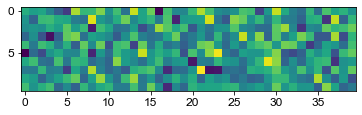

200 units per layer, 1 layer


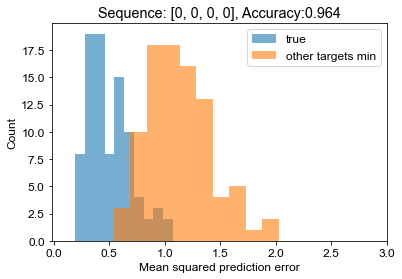

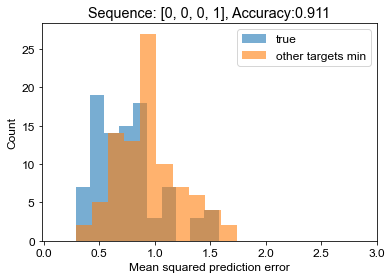

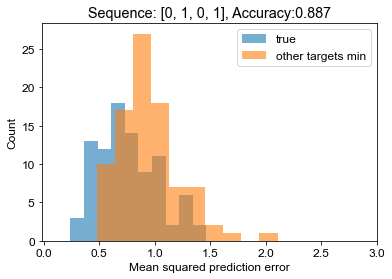

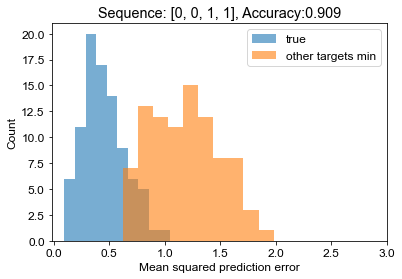

In [112]:
seq = [[0,0,0,0],[0,0,0,1],[0,1,0,1],[0,0,1,1]] # sequence structures to be used
seq_test = [[0,0,0,0],[0,0,0,1],[0,1,0,1],[0,0,1,1]]
Nseq = len(seq_test)
repeats = 10 # repeats per chunk in each sequence
input_size = 40 # dimensionality of the input
dict_size = 10 # size of stimulus dictionary
n_hidden = 200
n_layers = 1
Nback = 5 # how many items from last ! (5= whole sequence = 4 items + zero)
# create matrix of stimulus
#a = np.ones(input_size)
#dictionary = np.diag(a)[:dict_size,:]


ntrials = dict_size*dict_size - dict_size
Acc = np.zeros((Nseq,Nback,ntrials))
AngleAll = np.zeros((Nseq,Nback,ntrials,dict_size))

# produce random stimuli:
dictionary = np.random.randn(dict_size,input_size) # use same size as for the one-hot encoding
    
plt.imshow(dictionary)
plt.show()
    
# get unique pairs of stimuli
pairs = unique_pairs(dictionary)
    
# create training and test data
sequence = unique_pairs_sequence(seq,repeats,pairs)
test_sequence = unique_pairs_sequence(seq_test,repeats,pairs)
    
print('%s units per layer, %s layer'%(n_hidden,n_layers))
Yhat = np.zeros((ntrials,len(test_sequence),Nback,input_size)) # store prediction here
Ytrue = np.zeros((ntrials,len(test_sequence),Nback,input_size)) # store ground truth
Hidden = np.zeros((ntrials,len(test_sequence),Nback,n_hidden)) # hidden state activity
for k in range(ntrials):
    
    train_x = []
    train_y = []
    # create data from numpy arrrays
    for i in range(len(seq)):
        if i==0:
            trainind = np.delete(np.arange(ntrials),np.arange(int(k/dict_size)*(dict_size-1),(int(k/dict_size)+1)*(dict_size-1)))
        else:
            trainind = np.delete(np.arange(ntrials),k)
        train_x.append(torch.Tensor(sequence[i][trainind,:-2,:])) #!!-1 if no zero element after each chunk, otherwise -2
        train_y.append(torch.Tensor(sequence[i][trainind,-2,:])) #-2 because last element is zero state

    # train network
    model = RNN(n_hidden,n_layers,input_size)
    Loss = train_model(train_x,train_y, model)
    
    # predict last 4 items of sequence
    for j in range(Nback):
        
        test_x = []
        for i in range(Nseq):
            if j==Nback-1:
                test_x.append(torch.Tensor(test_sequence[i][k:k+1,:,:]))
            else:
                test_x.append(torch.Tensor(test_sequence[i][k:k+1,:-Nback+j+1 ,:]))

        y,h = predict(test_x,model)
    
        for i in range(Nseq):
            Yhat[k,i,j,:] = y[i][0,:] # hard coded!, works only if output 1 sample
            if j==Nback-1:
                Ytrue[k,i,j,:] = test_sequence[i][k,-5,:]
            else:
                Ytrue[k,i,j,:] = test_sequence[i][k,-Nback+j+1 ,:] # -1 because last item is zero state
            Hidden[k,i,j,:] = h[i][0][0,:].detach().numpy()
        

Error = np.zeros((len(test_sequence),ntrials))
Errordist = np.zeros((len(test_sequence),ntrials,dict_size-1))

for i in range(len(test_sequence)):
    for j in range(Nback): # items in sequence
        for k in range(ntrials):
            yhat = Yhat[k,i,j,:]
            ytrue = Ytrue[k,i,j,:]
            yrep = np.repeat(ytrue[None,:],dict_size,0)
            target_idx = np.argmin(np.mean(abs(yrep-dictionary),1))
            Error[i,k] = np.mean((yhat - ytrue)**2) # calculate mean squared error of predicted vector with ground truth
            yrep = np.repeat(yhat[None,:],dict_size-1,0)
            Errordist[i,k,:] = np.mean((yrep - np.delete(dictionary,target_idx,0))**2,1) # calculate mean squared error of predicted vector with ground truth
            # calculate ratio of samples equally small or smaller than sample
            Acc[i,j,k] = Error[i,k]<np.min(Errordist[i,k,]) #(np.min(Errordist[i,k,])-Error[i,k])/np.min(Errordist[i,k,]) 
        
            # angle with all vectors in dictionary
            yrep = np.repeat(yhat[None,:],dict_size,0)
            yrep = yrep/np.linalg.norm(yrep,1)
            dic = dictionary/np.linalg.norm(dictionary,1)
            for s in range(dict_size):
                AngleAll[i,j,k,s] = np.arccos(yrep[s,:]@dic[s,:]) * 180/np.pi
            
    ax = plt.subplot(111)
    plt.hist(Error[i,],label='true',alpha=.6)
    plt.hist(np.min(Errordist[i,],-1),label='other targets min',alpha=.6)
    ax.set_title('Sequence: %s, Accuracy:%.3f'%(seq_test[i],np.mean(Acc[i,:])))
    ax.set_xlabel('Mean squared prediction error')
    ax.set_xlim(-0.02,3)
    plt.ylabel('Count')
    plt.legend()
    #plt.savefig('NIP_error_seq_%s.png'%seq_test[i])
    plt.show()

### PCA

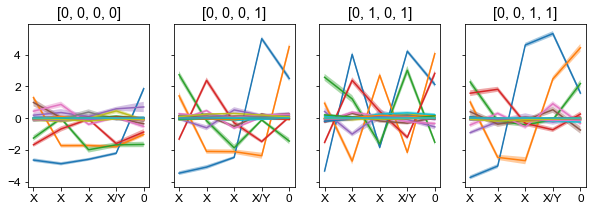

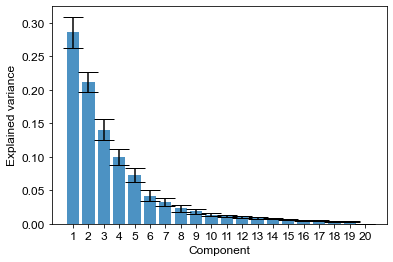

In [113]:
#fig,ax = plt.subplots(4,Nseq,figsize=(15,10))
ticks = ['X','X','X','X/Y','0']
n_comp = 20
n_stim = dict_size
Nseq = Hidden.shape[1]
n_pos = Hidden.shape[2]
col = np.random.rand(3,n_comp)
fig,ax = plt.subplots(1,Nseq,figsize=(10,3),sharey=True)

Proj = np.zeros((ntrials,Nseq,Hidden.shape[2],n_comp))
Varexp = np.zeros((ntrials,n_comp))
PCs = np.zeros((ntrials,n_comp,n_hidden))
for i in range(ntrials):
    hidden = np.reshape(Hidden[i,:,:,:],(Nseq*n_pos,n_hidden))
    #hidden = hidden - np.repeat(np.mean(hidden,0)[None,:],Nseq*Hidden.shape[2],0)
    principal = PCA(n_components = n_comp)
    principal.fit(hidden)
    x = principal.transform(hidden)
    proj = np.reshape(x,(Nseq,n_pos,n_comp))
    Proj[i,:,:,:] = proj
    Varexp[i,:]  = principal.explained_variance_ratio_
    PCs[i,:,:] = principal.components_
# plot    
for j in range(Nseq):# loop through seq
    m = np.mean(Proj[:,j,:,:],0)
    sem = np.std(Proj[:,j,:],0)/np.sqrt(ntrials)
    for n in range(n_comp):
        ax[j].plot(np.arange(n_pos),m[:,n])
        ax[j].fill_between(np.arange(n_pos),m[:,n]-sem[:,n],m[:,n]+sem[:,n],alpha=.4)

    ax[j].set_title(seq_test[j])
    ax[j].set_xticks(np.arange(n_pos))
    ax[j].set_xticklabels(ticks)
plt.show()

plt.bar(np.arange(n_comp),np.mean(Varexp,0),yerr=np.std(Varexp,0), alpha=.8,align='center', ecolor='black', capsize=10)
plt.xticks(np.arange(n_comp),np.arange(n_comp)+1)
plt.xlabel('Component')
plt.ylabel('Explained variance')
plt.savefig('NIP_decoding_Varexp.png')
plt.savefig('NIP_decoding_Varexp.pdf')
plt.show()

# Data

In [7]:
# imports
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
import pandas as pd
from glob import glob as glob
import os
from neo import io
import seaborn as sb
from sklearn import preprocessing
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams["font.size"]= 12
plt.rcParams["font.family"] = "Arial"

Load data and preprocess

In [8]:
# parameters
animal_id = 'A11' # A11, H07
exp = 'classical' # 'wang or classical
out_path = '/Volumes/Bellet/Local_Global/processedData/%s/'%animal_id # path to the data

# load preprocessed data
df = pd.read_pickle(os.path.join(out_path,'%s_stims_spikes_dataframe.pkl'%(animal_id)))

# extract basic variables
dates = np.unique(df.date)
ndates = len(dates)
nitems = np.max(df.ItemID)
stimID = np.unique(df.StimID)
nstim = len(stimID)
print(list(df.keys()))
print('Recording dates:',dates)

soa = 600
Local = []
Global = []
BlockID = []
Blocktype = []
Block = [] # which block
Include = []
Stimon = []
SessionDate = []
StimID = []
sess = 0
blocks = ['aa','aB','bb','bA'] # coded like this in the experiment
for d,date in enumerate(dates):


    
    # get conditions
    last_item = np.where((df.ItemID==3) & (df.date==date) )[0]#& ((df.StimDur+df.ISIDur)==soa))[0]
    Ntrials = len(last_item)
    if Ntrials>0:
        
        print('Day:',date)
        SessionDate.append(date)
        Local.append(np.zeros(Ntrials).astype(int))
        for i,ind in enumerate(last_item):
            if df.StimID.iloc[ind]!=df.StimID.iloc[ind-1]: # local deviant = transition of two stim
                Local[sess][i] = 1
        
        BlockID.append(np.array(df.blockID[last_item])) # blockID
        Block.append(np.array(df.blockType[last_item])) # which block (classical experiment: 0,1,2 or 3)
        Blocktype.append(np.zeros(Ntrials).astype(int)) # xx=0 xY=1
        for bl in np.unique(BlockID[sess]):
            ind = np.where(BlockID[sess]==bl)[0]
            Blocktype[sess][ind] = Local[sess][ind[0]] # blocktype defined by the first habituation trial in block
        
        Global.append((Local[sess]!=Blocktype[sess]).astype(int))
        
        # filter habituation trials
        nhab = 50
        Include.append(np.ones(len(Global[sess])).astype(int))
        for bl in np.unique(BlockID[sess]):
            ind = np.where(BlockID[sess]==bl)[0]
            Include[sess][ind[:nhab]] = 0
            
        Stimon.append(np.array(df.StimOn.iloc[last_item])) # last stim onset times
        StimID.append(np.array(df.StimID.iloc[last_item]))

        
        sess += 1
    
Session = np.concatenate([np.ones(len(Local[i]))*i for i in range(len(Local))])
Local = np.concatenate(Local)
Global = np.concatenate(Global)
Blocktype = np.concatenate(Blocktype)
Block = np.concatenate(Block)
Include = np.concatenate(Include)
StimID = np.concatenate(StimID)

# MUA
# load PSTH
MUA = []
sess = 0
for d,date in enumerate(dates):
    # get conditions
    last_item = np.where((df.ItemID==3) & (df.date==date) )[0]#& ((df.StimDur+df.ISIDur)==soa))[0]
    Ntrials = len(last_item)
    if Ntrials>0:
        
        print('Day:',date)
        
        # PSTH
        Rb = np.load(os.path.join(out_path,'Rb_seq_gauss_%s.npy'%date))
        time_bins = np.load(os.path.join(out_path,'time_bins_seq_gauss_%s.npy'%date))
        ntr,nch,nbins = Rb.shape
        # centre each channel
        Rc = Rb.copy()
        for ch in range(nch):
            Rc[:,ch,:] = (Rb[:,ch,:] - np.mean(Rb[:,ch,:])) / (np.std(Rb[:,ch,:]) + 10e-6) # centre each channel
        MUA.append(Rc)
        
        sess += 1
        
del Rb, Rc

MUA = np.concatenate(MUA)
nbins = len(time_bins)

['PFC_MU', 'PPC_MU', 'PFC_SU', 'PPC_SU', 'TrialID', 'ItemID', 'StimID', 'StimName', 'StimOn', 'blockID', 'blockType', 'date', 'StimDur', 'ISIDur', 'RewardOn']
Recording dates: ['20200226' '20200228' '20200305' '20200306' '20200311' '20200312']
Day: 20200226
Day: 20200228
Day: 20200305
Day: 20200306
Day: 20200311
Day: 20200312
Day: 20200226
Day: 20200228
Day: 20200305
Day: 20200306
Day: 20200311
Day: 20200312


In [101]:
# get days with matching and non-matching stimuli
ImID = []
for d in dates:
    stim = np.unique(df.StimName[df.date==d])
    ImID.append(stim)

first = [ImID[i][0] for i in range(nsess)]
stims = np.unique(first)
nunique = len(stims)
which_stim = [np.where(np.array(first)==stims[i])[0] for i in range(nunique)]


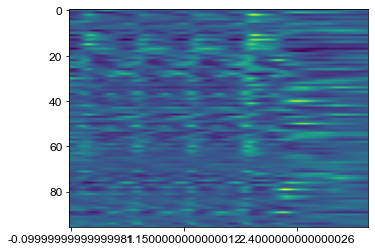

In [9]:
plt.imshow(np.mean(MUA,0))
plt.xticks(np.arange(0,nbins,50),time_bins[np.arange(0,nbins,50)])
plt.show()

In [114]:
# bin signal
soa = .6
timewindows = [[0.10,0.350],[soa+0.10,soa+0.350],[2*soa+0.10,2*soa+0.350],[3*soa+0.10,3*soa+0.350],[3*soa+0.600,3*soa+0.800]]
Neural = np.zeros((MUA.shape[0],nch,len(timewindows)))
for i in range(len(timewindows)):
    tmin = np.argmin(abs(time_bins-timewindows[i][0]))
    tmax = np.argmin(abs(time_bins-timewindows[i][1]))
    Neural[:,:,i] = np.mean(MUA[:,:,tmin:tmax+1],-1)
    
    

In [116]:
ANN = np.mean(Proj[:,[0,1],:,:],0) # average trials and use sequences XXXX and XXXY
ANN.shape

(2, 5, 20)

In [117]:
from sklearn.linear_model import LinearRegression# do regression per session but here not
nperm = 100

RegScore = np.zeros((nunique,n_comp))
RandScore = np.zeros((nunique,n_comp,nperm))
RegCoef = np.zeros((nunique,nch,n_comp))
NeuralProj = np.zeros((MUA.shape[0],nbins,n_comp))
P = np.zeros((nunique,n_comp))
    
for s in range(nunique):
    print('Stimulus pair %s'%s)
    session = np.array([first[i]==stims[s] for i in range(len(first))]) # identify session with this stimulus pair
    testind = []
    for a,which_session in enumerate(np.where(session==True)[0]):
        testind.extend(np.where(Session==which_session)[0])
    trainind = np.delete(np.arange(Neural.shape[0]),testind)
    NNN = np.zeros((ANN.shape[0],ANN.shape[1],nch))
    NNNtest = np.zeros((ANN.shape[0],ANN.shape[1],nch))
    for i in range(2): # select xxxx and xxxy
        ind = (Local[trainind]==i) & (Global[trainind]==0) # only global standards
        indtest = (Local[testind]==i) & (Global[testind]==0)
        NNN[i,:] = np.mean(Neural[trainind,:][ind==True,:],0).T
        NNNtest[i,:] = np.mean(Neural[testind,:][indtest==True,:],0).T
        
    # centre each channel and components
    for c in range(n_comp):
        ANN[:,:,c] -= np.mean(ANN[:,:,c])
        ANN[:,:,c] /= np.std(ANN[:,:,c])  
    for ch in range(nch):
        NNN[:,:,ch] -= np.mean(NNN[:,:,ch])
        NNN[:,:,ch] /= np.std(NNN[:,:,ch])
        NNNtest[:,:,ch] -= np.mean(NNNtest[:,:,ch])
        NNNtest[:,:,ch] /= np.std(NNNtest[:,:,ch])
    
    # regression per component
    
    for c in range(n_comp):
        X = np.reshape(NNN,(2*n_pos,nch))
        Xtest = np.reshape(NNNtest,(2*n_pos,nch))
        Y = np.reshape(ANN[:,:,c],2*n_pos)
        
        
        reg = LinearRegression().fit(X,Y)
        RegScore[s,c] = reg.score(Xtest,Y)
        # random permutation: scramble time points of ANN dynamics and test fit
        for n in range(nperm):
            RandScore[s,c,n] = reg.score(Xtest,Y[np.random.permutation(n_pos*2)])
        P[s,c] = np.mean(RandScore[s,c,:]>=RegScore[s,c])
        # for visualization: 
        Neuraltest = MUA[testind,:]
        for ch in range(nch):
            Neuraltest[:,ch,:] -= np.mean(Neuraltest[:,ch,:])
            Neuraltest[:,ch,:] /= np.std(Neuraltest[:,ch,:])
        # project test trials individually onto axes
        for p in range(nbins):
            NeuralProj[testind,p,c] = reg.predict(Neuraltest[:,:,p])


Stimulus pair 0
Stimulus pair 1
Stimulus pair 2
Stimulus pair 3


[0.0025 0.1725 0.235  0.1325 0.1225 0.165  0.0925 0.0125 0.0275 0.175
 0.1775 0.11   0.085  0.035  0.18   0.35   0.1975 0.035  0.0425 0.1275]


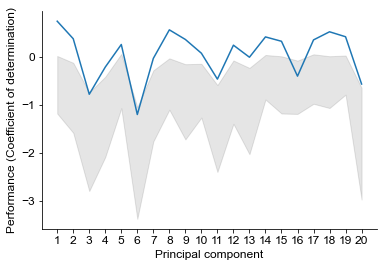

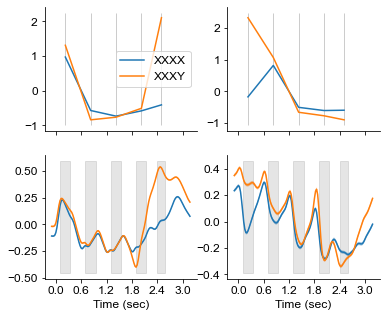

In [90]:
ax = plt.subplot(111)
plt.plot(np.mean(RegScore,0).T)
rand = np.reshape(np.swapaxes(RandScore,0,1),(n_comp,nunique*nperm))
plt.fill_between(np.arange(n_comp),np.mean(rand,1)-np.std(rand,1),
                 np.mean(rand,1)+np.std(rand,1),color='k',alpha=.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(np.arange(n_comp),np.arange(n_comp)+1)
plt.xlabel('Principal component')
plt.ylabel('Performance (Coefficient of determination)')
p = np.mean(P,0)
print(p)
plt.show()


plot_comp = 2
fig,ax = plt.subplots(2,plot_comp,figsize=(plot_comp*3,5),sharex=True)
labels = ['XXXX','XXXY']
for c in range(plot_comp):
    for i in range(2):
        # plot RNN components
        x = [timewindows[j][0]+np.diff(timewindows[j])/2 for j in range(n_pos)]
        ax[0,c].plot(x,ANN[i,:,c],label=labels[i])
        
        m = np.mean(NProj[(Local==i) & (Global==0),:,c],0)
        sem = np.std(NProj[(Local==i) & (Global==0),:,c],0)/np.sqrt(sum((Local==i) & (Global==0)))
        ax[1,c].plot(time_bins,m)
        ax[1,c].fill_between(time_bins,m-sem,m+sem,alpha=.4)
        ax[i,c].spines['top'].set_visible(False)
        ax[i,c].spines['right'].set_visible(False)
    ymin,ymax = ax[1,c].get_ylim()
    ymin0,ymax0 = ax[0,c].get_ylim()
    for p in range(n_pos):
        ax[0,c].fill_between(timewindows[p][0]+np.diff(timewindows[p])/2,ymin0,ymax0,color='k',alpha=.2)
        ax[1,c].fill_between(np.arange(timewindows[p][0],timewindows[p][1],.01),ymin,ymax,color='k',alpha=.1)
    ax[1,c].set_xlabel('Time (sec)')
ax[0,0].legend()
ax[0,0].set_xticks(np.arange(0,time_bins[-1],soa))
plt.show()

align and test within the same stimulus pair

In [126]:
from sklearn.linear_model import LinearRegression# do regression per stimulus pair
nperm = 100
nsess = int(np.max(Session)+1)
fold_cv = 10
RegScore = np.zeros((nsess,n_comp,fold_cv))
RandScore = np.zeros((nsess,n_comp,nperm,fold_cv))
P = np.zeros((nsess,n_comp,fold_cv))
NProj = np.zeros((MUA.shape[0],nbins,n_comp))
RegCoef = np.zeros((nsess,n_comp,nch,fold_cv))
for sess in range(nsess):
    print('Session %s'%sess)
    sessind = (Session==sess) #& (Global==0)
    nsession = sum(sessind)
    ntest = int(nsession*.1)
    proj = np.zeros((nsession,nbins,n_comp))
    shuffled = np.random.permutation(nsession)
    for k in range(fold_cv):
        testind = np.arange(k*ntest,(k+1)*ntest)
        trainind = np.delete(np.arange(nsession),testind)
        NNN = np.zeros((ANN.shape[0],ANN.shape[1],nch))
        NNNtest = np.zeros((ANN.shape[0],ANN.shape[1],nch))
        for i in range(2): # select xxxx and xxxy
            ind = Local[sessind][shuffled][trainind]==i # select for session, then training samples
            indtest = Local[sessind][shuffled][testind]==i
            NNN[i,:] = np.mean(Neural[sessind][shuffled][trainind,:][ind==True,:],0).T
            NNNtest[i,:] = np.mean(Neural[sessind][shuffled][testind,:][indtest==True,:],0).T
            
        # centre each channel and components
        for c in range(n_comp):
            ANN[:,:,c] -= np.mean(ANN[:,:,c])
            ANN[:,:,c] /= np.std(ANN[:,:,c])  
        for ch in range(nch):
            NNN[:,:,ch] -= np.mean(NNN[:,:,ch])
            NNN[:,:,ch] /= np.std(NNN[:,:,ch])
            NNNtest[:,:,ch] -= np.mean(NNNtest[:,:,ch])
            NNNtest[:,:,ch] /= np.std(NNNtest[:,:,ch])
    
        # regression per component
        proj = np.zeros((len(testind),nbins,n_comp))
        for c in range(n_comp):
            X = np.reshape(NNN,(2*n_pos,nch))
            Xtest = np.reshape(NNNtest,(2*n_pos,nch))
            Y = np.reshape(ANN[:,:,c],2*n_pos)
            
            
            reg = LinearRegression().fit(X,Y)
            RegScore[sess,c,k] = reg.score(Xtest,Y)
            RegCoef[sess,c,:,k] = reg.coef_
            # random permutation: scramble time points of ANN dynamics and test fit
            for n in range(nperm):
                RandScore[sess,c,n,k] = reg.score(Xtest,Y[np.random.permutation(n_pos*2)])
            P[sess,c,k] = np.mean(RandScore[sess,c,:,k]>=RegScore[sess,c,k])
            
            # for visualization: (just some components)
            
            if c<5:
                Neuraltest = MUA[sessind,:][shuffled,:][testind,:]
                # centre
                for ch in range(nch):
                    Neuraltest[:,ch,:] -= np.mean(Neuraltest[:,ch,:])
                    Neuraltest[:,ch,:] /= np.std(Neuraltest[:,ch,:])
                # project test trials individually onto axes
                for p in range(nbins):
                    proj[:,p,c] = reg.predict(Neuraltest[:,:,p]).copy()
        indices = np.where(sessind==True)[0][shuffled][testind]
        NProj[indices,:,:] = proj
            


Session 0
Session 1
Session 2
Session 3
Session 4
Session 5


Plot

[3.33333333e-04 1.66666667e-04 2.13333333e-02 3.18333333e-02
 8.33333333e-02 1.20000000e-02 5.18333333e-02 2.11833333e-01
 5.00000000e-03 5.83333333e-03 3.15333333e-01 3.01666667e-02
 5.66666667e-03 1.15000000e-02 3.58333333e-02 8.33333333e-04
 4.66666667e-03 2.31666667e-02 2.35000000e-02 1.25000000e-02]


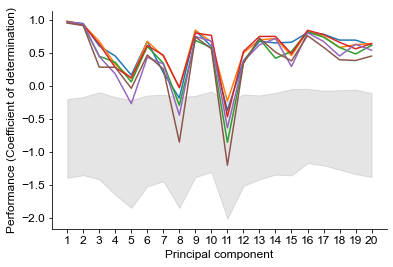

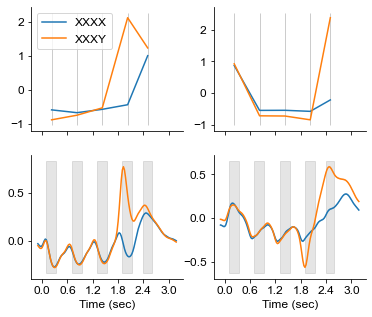

In [123]:
ax = plt.subplot(111)
plt.plot(np.mean(RegScore,-1).T)
rand = np.reshape(np.swapaxes(RandScore,0,1),(n_comp,nsess*nperm*fold_cv))
plt.fill_between(np.arange(n_comp),np.mean(rand,1)-np.std(rand,1),
                 np.mean(rand,1)+np.std(rand,1),color='k',alpha=.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(np.arange(n_comp),np.arange(n_comp)+1)
plt.xlabel('Principal component')
plt.ylabel('Performance (Coefficient of determination)')
p = np.mean(np.mean(P,-1),0)
print(p)
plt.savefig('NIP_Alignment_Performance.pdf')
plt.savefig('NIP_Alignment_Performance.png')
plt.show()


plot_comp = 2
fig,ax = plt.subplots(2,plot_comp,figsize=(plot_comp*3,5),sharex=True)
labels = ['XXXX','XXXY']
for c in range(plot_comp):
    for i in range(2):
        # plot RNN components
        x = [timewindows[j][0]+np.diff(timewindows[j])/2 for j in range(n_pos)]
        ax[0,c].plot(x,ANN[i,:,c],label=labels[i])
        
        m = np.mean(NProj[(Local==i) & (Global==0),:,c],0)
        sem = np.std(NProj[(Local==i) & (Global==0),:,c],0)/np.sqrt(sum((Local==i) & (Global==0)))
        ax[1,c].plot(time_bins,m)
        ax[1,c].fill_between(time_bins,m-sem,m+sem,alpha=.4)
        ax[i,c].spines['top'].set_visible(False)
        ax[i,c].spines['right'].set_visible(False)
    ymin,ymax = ax[1,c].get_ylim()
    ymin0,ymax0 = ax[0,c].get_ylim()
    for p in range(n_pos):
        ax[0,c].fill_between(timewindows[p][0]+np.diff(timewindows[p])/2,ymin0,ymax0,color='k',alpha=.2)
        ax[1,c].fill_between(np.arange(timewindows[p][0],timewindows[p][1],.01),ymin,ymax,color='k',alpha=.1)
    ax[1,c].set_xlabel('Time (sec)')
ax[0,0].legend()
ax[0,0].set_xticks(np.arange(0,time_bins[-1],soa))
plt.savefig('NIP_Alignment_Examples.pdf')
plt.savefig('NIP_Alignment_Examples.png')
plt.show()

### Similarity of regression coefficients (NNN) and principal components (RNN)

In [42]:
RegCoef.shape

(6, 20, 96, 10)

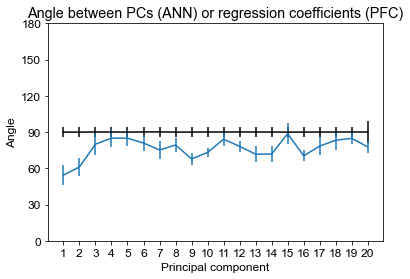

In [120]:
# pairwise angle between all PCs
ANNAngles = np.zeros((ntrials*ntrials-ntrials,n_comp))

for comp in range(n_comp):
    n = 0
    for i in range(ntrials):
        for j in range(ntrials):
            if i!=j:
                v1 = PCs[i,comp,:]/np.linalg.norm(PCs[i,comp,:])
                v2 = PCs[j,comp,:]/np.linalg.norm(PCs[j,comp,:])
                ANNAngles[n,comp] = np.arccos(v1@v2) * 180/np.pi
                n += 1


# pairwise angle between all PCs
NNNAngles = np.zeros((nunique*nunique-nunique,n_comp))
#NNNAngleswithin = np.zeros((nsess,fold_cv*fold_cv-fold_cv,n_comp))
MeanCoef = np.mean(RegCoef,-1) # average crossvalidation folds

## angles within folds of each session
#for sess in range(nsess):
#    for comp in range(n_comp):
#        n = 0
#        for i in range(fold_cv):
#            for j in range(fold_cv):
#                if i!=j:
#                    v1 = RegCoef[sess,comp,:,i]/np.linalg.norm(RegCoef[sess,comp,:,j])
#                    v2 = RegCoef[sess,comp,:,i]/np.linalg.norm(RegCoef[sess,comp,:,i])
#                    NNNAngleswithin[sess,n,comp] = np.arccos(v1@v2) * 180/np.pi
#
#                    n += 1
# angles between average vectors between sessions  
for comp in range(n_comp):
    n = 0
    for i in range(nunique):
        for j in range(nunique):
            if i!=j:
                C1 = np.mean(MeanCoef[which_stim[i],comp,],0)
                C2 = np.mean(MeanCoef[which_stim[j],comp,],0)
                v1 = C1/np.linalg.norm(C1)
                v2 = C2/np.linalg.norm(C2)
                NNNAngles[n,comp] = np.arccos(v1@v2) * 180/np.pi
                n += 1
ax = plt.subplot(111)
plt.yticks(np.arange(0,181,30))
plt.errorbar(np.arange(n_comp),np.mean(ANNAngles,0),yerr=np.std(ANNAngles,0),color='k',label='ANN')
plt.errorbar(np.arange(n_comp),np.mean(NNNAngles,0),yerr=np.std(NNNAngles,0),label='PFC')
#plt.errorbar(np.arange(n_comp),np.mean(np.nanmean(NNNAngleswithin,0),0),yerr=np.std(np.mean(NNNAngleswithin,1),0))

plt.ylim(0,180)
plt.xticks(np.arange(n_comp),np.arange(n_comp)+1)
plt.xlabel('Principal component')
plt.ylabel('Angle')
plt.title('Angle between PCs (ANN) or regression coefficients (PFC)')
plt.savefig('NIP_PCA_angles.pdf')
plt.savefig('NIP_PCA_angles.png')
plt.show()

### Plot trial types (Global st/dev)

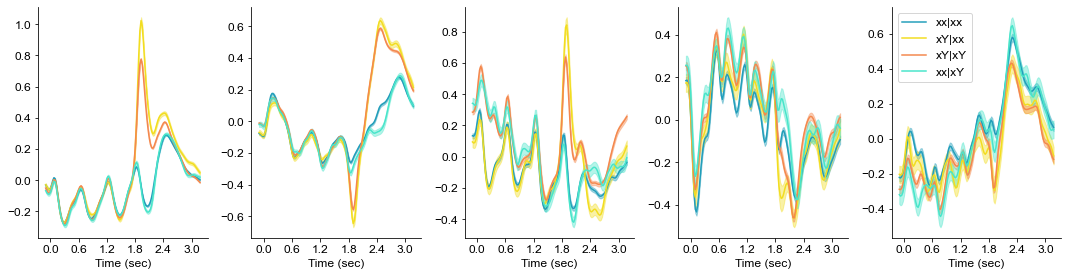

In [128]:
plot_comp = 5
fig,ax = plt.subplots(1,plot_comp,figsize=(plot_comp*3,4),sharex=True)
colors = [['#229eba','#f2dd20'], # xx block
         ['#f4884d','#48e5ca']] # xY block
labels = [['xx|xx','xY|xx'],['xY|xY','xx|xY']]
for c in range(plot_comp):
    for i in range(2):
        for j in range(2):
        # plot RNN components
        
            m = np.mean(NProj[(Blocktype==i) & (Global==j),:,c],0)
            sem = np.std(NProj[(Blocktype==i) & (Global==j),:,c],0)/np.sqrt(sum((Blocktype==i) & (Global==j)))
            ax[c].plot(time_bins,m,color=colors[i][j],label=labels[i][j])
            ax[c].fill_between(time_bins,m-sem,m+sem,alpha=.4,color=colors[i][j])
    ax[c].spines['top'].set_visible(False)
    ax[c].spines['right'].set_visible(False)
    
    ax[c].set_xlabel('Time (sec)')
ax[-1].legend()
ax[0].set_xticks(np.arange(0,time_bins[-1],soa))
plt.tight_layout()
plt.savefig('NIP_Alignment_Trialtypes.pdf')
plt.savefig('NIP_Alignment_Trialtypes.png')
plt.show()